# Table of contents
1. [Package Imports](#imports)
2. [Data Import](#dataimport)
3. [Exploration](#explore)   
    1. [Data Profile](#profile)
    2. [Data Preprocessing](#preprocess)
    3. [Missing Values](#missing)
    4. [EDA & Feature Engineering](#eda)
        1. [Boxplot of Appliances Wh on Hour](#boxplot_appliances)
        2. [Matrix Scatterplot of Feature Importance](#top_features)
    5. [Data Skewness](#skewness)
    6. [Data Outliers](#outlier)
4. [Modelling](#model)
    1. [Train/Test Split](#train_test)
    2. [Linear Regression](#lr)
        1. [LR Preidction Plot](#lr_predict_plot)
        2. [LR Residual Plot](#lr_residual)
    3. [XGBoost Regression](#xgboost)
        1. [XGBoost Prediction Plot](#xgboost_predict_plot)
        2. [XGBoost Residual Plot](#xgboost_residual)
        3. [XGBoost Feature Importance](#xgboost_feature)
        4. [SHAP](#shap)
5. [Benefits](#benefits)
    1. [Micro Level](#micro)
    2. [Macro Level](#macro)

---

## Imports <a name="imports"></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from scipy.stats import norm, skew 
from scipy.special import boxcox
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from yellowbrick.regressor import PredictionError, ResidualsPlot

import rt_imports as rt # custom class/functions
shap.initjs()

/Users/charlielu/anaconda3/envs/rio_tinto/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/charlielu/anaconda3/envs/rio_tinto/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/charlielu/anaconda3/envs/rio_tinto/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/charlielu/anaconda3/envs/rio_tinto/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/charlielu/anaconda3/envs/rio_tinto/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fil

---

## Data import <a name="dataimport"></a>

In [2]:
# Read in the dataframe using pandas
# parse_dates specifies the column with datetime
# dayfirst needs to be set to true 
parse_dates = ['date']
df = pd.read_csv('energydata.csv', low_memory=False, parse_dates=parse_dates, dayfirst=True)

In [3]:
# check that the date has been imported properly
df.date.dtype

dtype('<M8[ns]')

In [4]:
# original data shape
df.shape

(19735, 29)

In [5]:
# have a look at what the data looks like
df.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00        60.0    30.0  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00        60.0    30.0  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00        50.0    30.0  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:30:00        50.0    40.0  19.89  46.066667  19.2  44.590000   
4 2016-01-11 17:40:00        60.0    40.0  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4    ...             T9   RH_9     T_out  \
0  19.79  44.730000  19.000000    ...      17.033333  45.53  6.600000   
1  19.79  44.790000  19.000000    ...            NaN  45.56  6.483333   
2  19.79  44.933333  18.926667    ...      17.000000  45.50  6.366667   
3  19.79  45.000000  18.890000    ...      17.000000  45.40  6.250000   
4  19.79  45.000000  18.890000    ...      17.000000  45.40  6.133333   

   Press_mm_hg  RH_out  Windspeed  Visibility  Tdewpoint         v1         v2  
0        733.5    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1        733.6    92.0   6.666667         NaN        5.2  18.606195  18.606195  
2          NaN    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3        733.8     NaN   6.000000   51.500000        5.0  45.410390  45.410390  
4        733.9     NaN   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

---

# Exploration <a name="explore"></a>

## Profile the data <a name="profile"></a>

**Pandas profiler is a one stop shop that checks the data for missing, skewness, correlated **

In [6]:
pandas_profiling.ProfileReport(df)

From the profiling report, there are four issues identified: <br>
- High correlation between T9 and T7
- High correlation between T_out and T6
- High correlation AND cardinality between v1 and v2
- High amount of zeros in lights

## Data Preprocessing<a name="preprocess"></a>

*NOTE: Technically we should be splitting into train/test first to avoid data leakage from data imputation but since we are only dropping columns and filling in missing from other correlated features, I don't **think** there should be any data leakage issues.*

**v1 and v2**

Dropping v1 and v2 as they correlated and also extremely high cardinality(all unique values) 

In [7]:
df.drop(['v1','v2'], axis=1, inplace=True)

---

**T9 and T7**

Check correlation of T9 and T7 to Appliances value to determine which one to drop

In [8]:
df['Appliances'].corr(df['T9'])

0.006602439586903022

In [9]:
df['Appliances'].corr(df['T7'])

0.017278630462000757

Scatter plot the two variables to see relationship

<Figure size 1200x800 with 0 Axes>

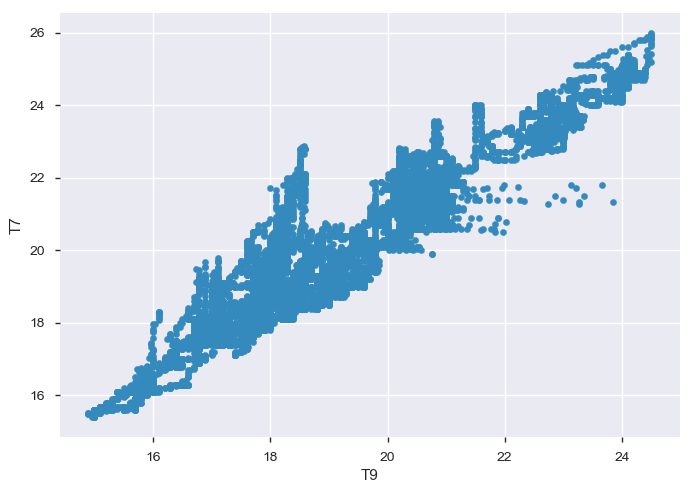

In [10]:
plt.figure(figsize = (12,8))
df.plot.scatter(x = 'T9', y= 'T7')

Since the pattern looks linear in nature, lets use it to fill in NA values in T7. This might make sense as the only time the ironing room(T7) is used is when the parents are home(T9).

In [11]:
sum(df['T7'].isnull())

3742

In [12]:
df['T7'] = df['T7'].fillna(value = df['T9'])

In [13]:
sum(df['T7'].isnull())

2665

Dropping feature 'T9' since 'T7' has higher coorelation to Appliances

In [14]:
df.drop(['T9'],axis = 1, inplace = True)

---

**T6 & T_out**

Makes sense that T6 and T_out would be correlated with each other, they are both measuring outside temperature.

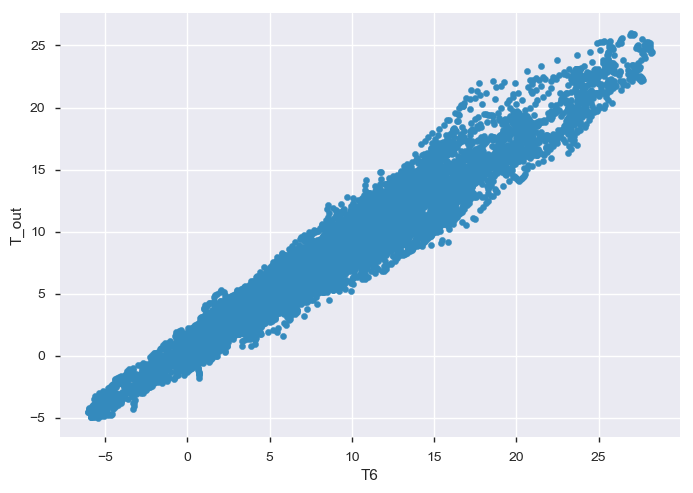

In [15]:
df.plot.scatter(x = 'T6', y= 'T_out')

Pretty much a linear relationship between the two features.

Check how much are missing and the correlation to Appliances

In [16]:
sum(df['T6'].isnull())

3849

In [17]:
sum(df['T_out'].isnull())

1418

In [18]:
df['T6'].corr(df['Appliances'])

0.11800224160046076

In [19]:
df['T_out'].corr(df['Appliances'])

0.1001100991626089

We should drop T6 instead of T_out since T_out has way less missing values but we will also fill missing values in T_out with T6 values

In [20]:
df['T_out'] = df['T_out'].fillna(value = df['T6'])

In [21]:
sum(df['T_out'].isnull())

266

In [22]:
df.drop(['T6'],axis = 1, inplace = True)

---

## Missing values<a name="missing"></a>

Lets have a look at data visually to identify any patters in missing values

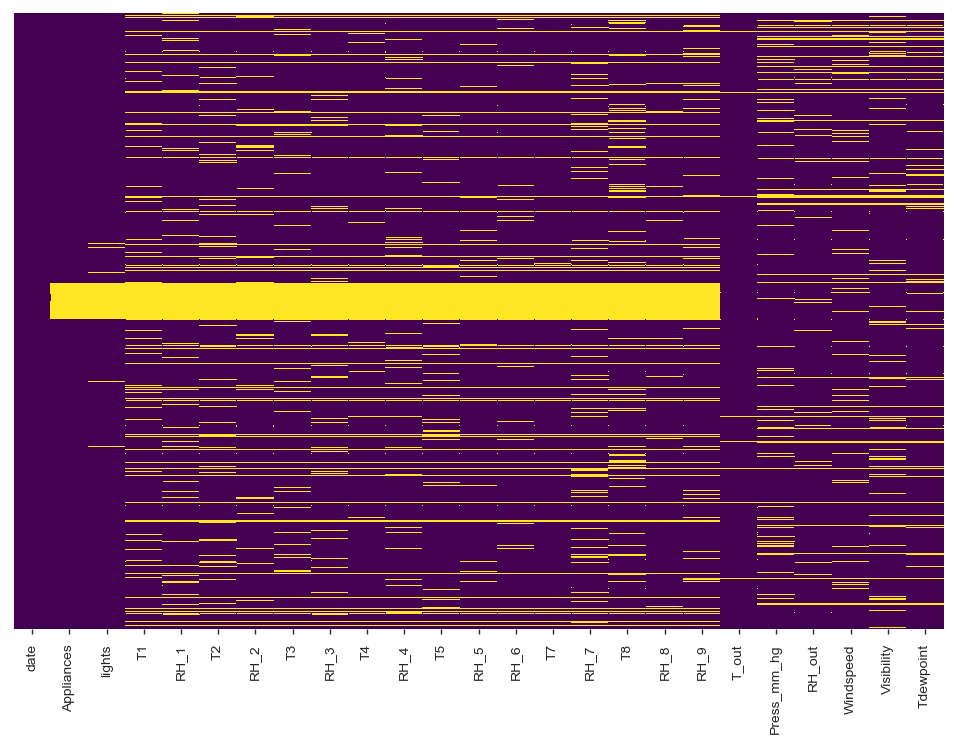

In [23]:
# Visualize the missing values using Seaborn to find patterns, yellow = missing.
plt.figure(figsize = (12,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis') 

There seems to be a large chunk of data missing completely for the internal house sensors.

From the large block of missing data in the middle, same pattern where Appliance Wh usage is not reported and all subsequent data is missing with only the weather station data remaining.<br>
Safe to assume the data is **MNAR**(missing not an random) as it seems to be a failure of sensor.

In [24]:
df.Appliances.isnull().sum()

1151

In [25]:
df.shape[0]

19735

Around 6% of the data, should be safe to remove as it is useless to us anyways (will not affect the Standard Error too much). <br> For more accurate modelling in future, might keep the data of the weather station for seperate modelling.

In [26]:
df = df.dropna(subset=['Appliances'])

Let's check the data again

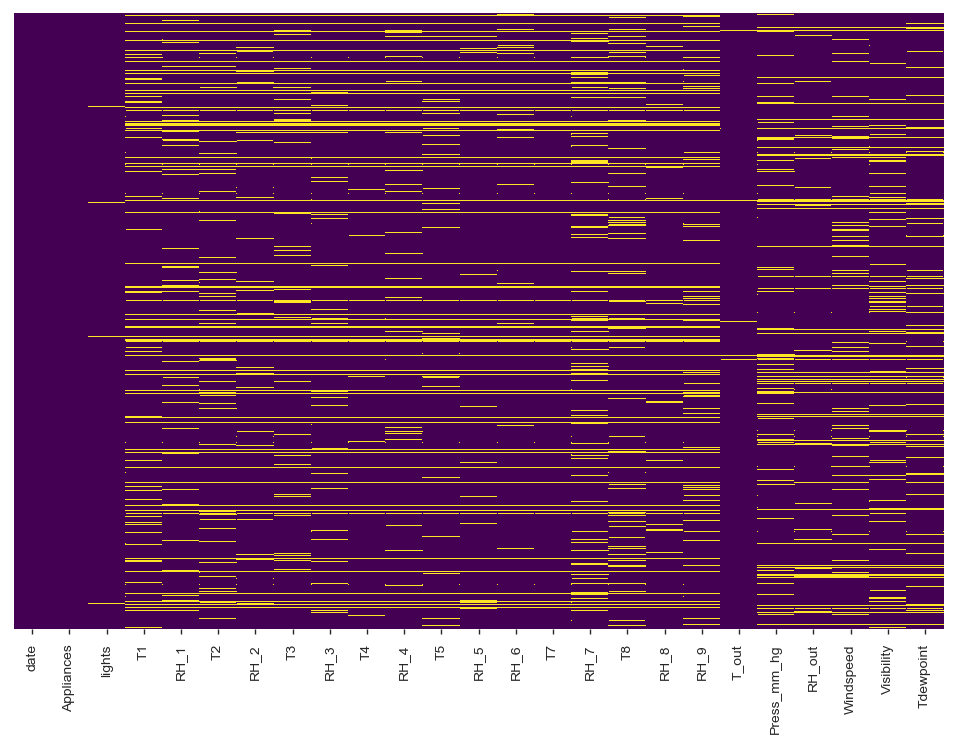

In [27]:
# Visualize the missing values using Seaborn to find patterns, yellow = missing.
plt.figure(figsize = (12,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis') 

**Imputing rest of the missing value**

*Going to cheat here by imputing before we train/test split the data and risk data leakage, if this was an actual project and in production, my thoughts would probably be using something like an ARIMA model for the training data and finding the seasonality and trends in the data for imputation in the test data. For keeping this project within scope and time limit, will just be imputing on the complete set*

For imputing the missing sensor data, we will take the average of the 3 data points before and 3 after (1 hour period). 

In [72]:
# create an pandas index object of column names which we want process, excluding date and appliances
df_index = df.iloc[:,2:].columns

In [71]:
df_index

Index(['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
       'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'RH_9', 'T_out', 'Press_mm_hg',
       'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'hr_sin', 'hr_cos'],
      dtype='object')

In [29]:
# recursively fill in the missing value
while sum(df.isnull().sum()) != 0:
    for index in df_index:
        df[index] = df[index].fillna(df[index].rolling(6, min_periods =1).mean())

---

## EDA and Feature Engineering<a name="eda"></a>

In [30]:
# set the index to date column so we can groupby datetime values
#df_temp = df.copy().set_index('date')
df = df.set_index('date')

In [31]:
df['hour'] = df.index.hour

### Boxplot of Appliances Wh on hour<a name="boxplot_appliances"></a>

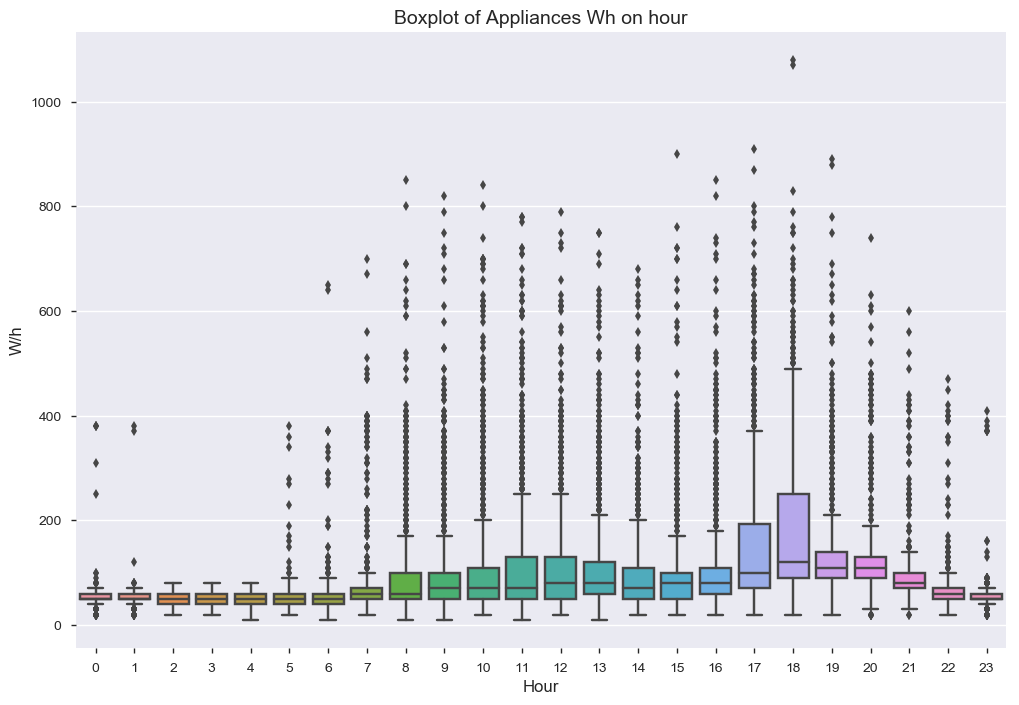

In [32]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'hour', y = 'Appliances', data = df)
plt.ylabel('W/h', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.title('Boxplot of Appliances Wh on hour', fontsize = 14)
plt.show()

There seems to be a pattern with the hours and W/h usage. <br>
We are going to create a new feature from the hours variable to better reflect the cyclical nature of time. e.g: 01:00 is closer to 23:00 than to 04:00

In [33]:
# from http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
df['hr_sin'] = np.sin(df.index.hour*(2.*np.pi/24))
df['hr_cos'] = np.cos(df.index.hour*(2.*np.pi/24))

In [34]:
df.drop(['hour'], inplace = True, axis = 1)

**Matrix Scatterplot**

In [35]:
# Top 8 most correlated features 
df.corr()['Appliances'].sort_values(ascending=False)[1:9]

lights       0.199087
T2           0.119291
T_out        0.098476
RH_1         0.094066
T3           0.082978
Windspeed    0.074196
T1           0.056706
RH_3         0.042949
Name: Appliances, dtype: float64

In [36]:
df_top = df.corr()['Appliances'].sort_values(ascending=False)[0:9].index

### Matrix Scatterplot of top features<a name="top_features"></a>

<Figure size 1200x800 with 0 Axes>

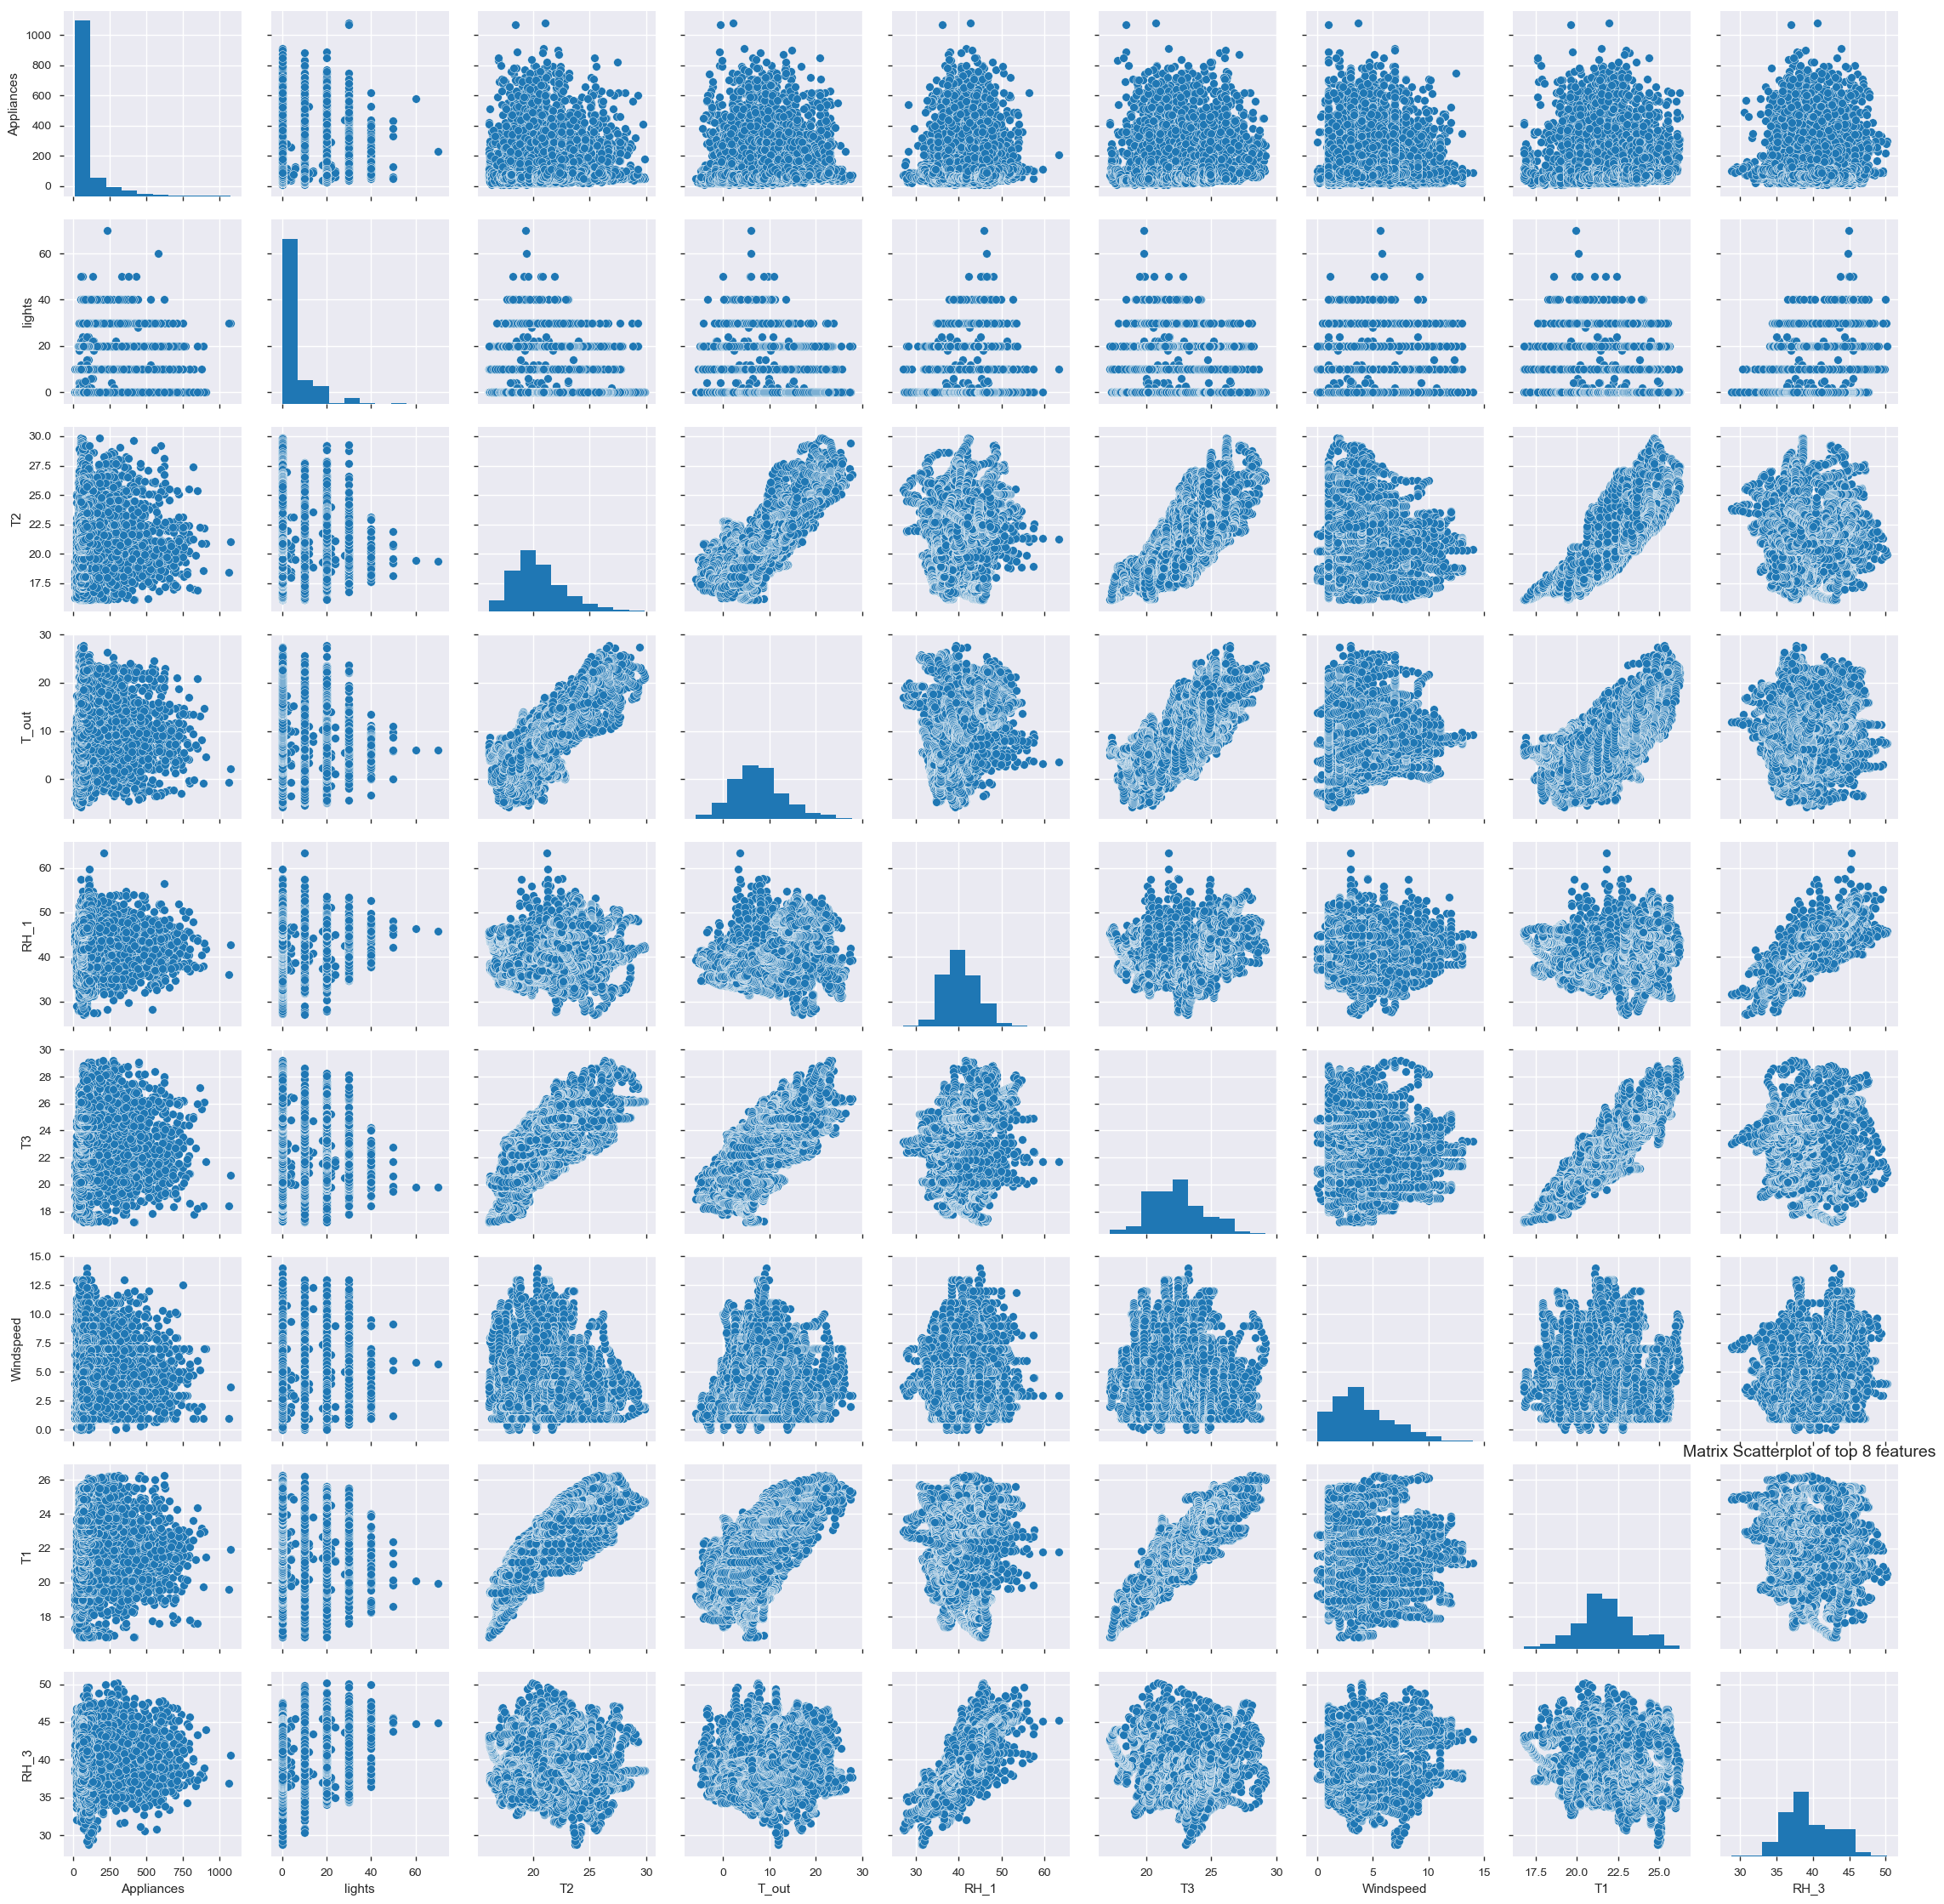

In [37]:
plt.figure(figsize=(12,8))
sns.pairplot(df[df_top])
plt.title('Matrix Scatterplot of top 8 features', fontsize = 14)
plt.show()

There doesn't seem to be a direct linear relationship between the target and predictors, we can validate this later with residual plots from linear regression.

## Data skewness <a name="skewness"></a>

Check which features are significantly skewed

In [38]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

Using Bulmer as rule of thumb for thresholding the skewness, anything higher than 1 is highly skewed

In [39]:
# Check the skew of all numerical features
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[skewness.Skew > 1]

In [40]:
skewness

Skew
Appliances  3.406461
lights      2.200769
RH_5        1.840997

Using Bulmer as rule of thumb for thresholding the skewness, anything higher than 1 is highly skewed

In [41]:
# Apply Box-Cow transform to the skewed features
for feat in ['Appliances', 'RH_5']:
    df[feat] = boxcox(df[feat], 0.15)

In [42]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [43]:
# Check the skew of all numerical features
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()

Skew
lights      2.200769
Appliances  1.496169
RH_5        1.263925
T2          0.865978
Windspeed   0.843864

## Data Outlier <a name="outlier"></a>

Check to see if there are any significant outliers in our target.

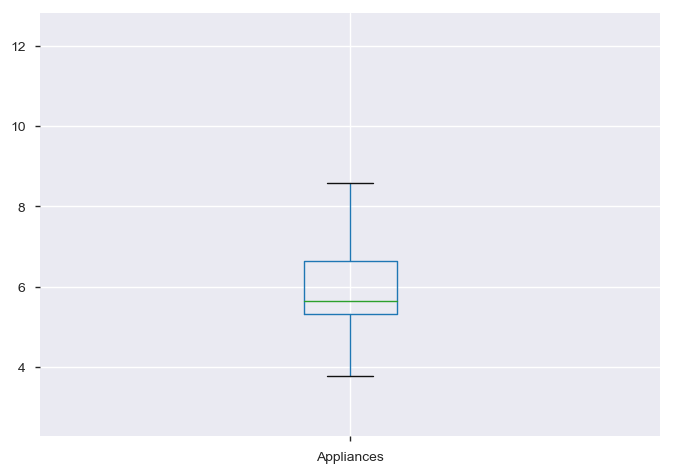

In [44]:
df.boxplot(column = 'Appliances')

In [45]:
df.Appliances.describe()

count    18584.000000
mean         6.104157
std          1.330211
min          2.750250
25%          5.321541
50%          5.653921
75%          6.635082
max         12.340715
Name: Appliances, dtype: float64

Lets remove the significant outliers above 3 S.D

In [46]:
df[df.Appliances > 10].count().Appliances

378

About 2% of the data

In [47]:
df = df[df.Appliances < 10]

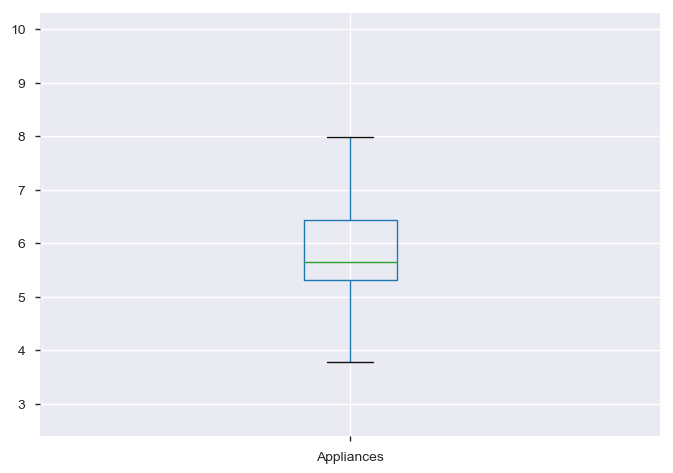

In [48]:
df.boxplot(column = 'Appliances')

/Users/charlielu/anaconda3/envs/rio_tinto/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


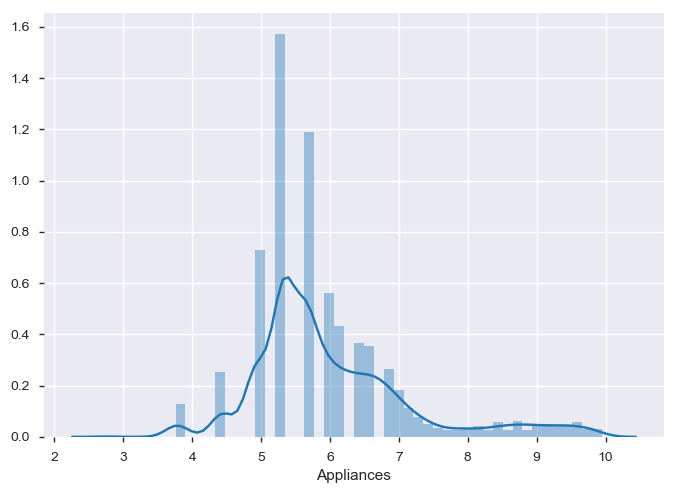

In [49]:
sns.distplot(df['Appliances'])

---

# Modelling<a name="model"></a>

## Data Train/Test Split<a name="train_test"></a>

As mentioned in beginning, splitting the data into train and test set should be done before we impute missing values, this avoids any data leakage issues. However, given scope and time limit of this coding challenge we have skipped this. <br>
Data scaling has not been done as linear regression and XGBoost models are not influenced. <br><br>
**Reason for choosing to not use Autoregressive models such as ARIMA or Facebook's Prophet to model time series data:** <br>
- Coding challenge specifically asks for prediction given the internal and external environment conditions.
- Seperate attempt and EDA done on the data (not shown in this notebook), did not show any promising patterns/trends from the time vs appliance data. <br>

**Risk in applying machine learning methods to time series data** <br>
- ML models such as Linear regression assumes that the observations are independent 
- Autocorrelation
- Extrapolation to future unseen data
- Seasonality/Trends not captured

In [50]:
LR = LinearRegression()

In [51]:
X = df.drop(['Appliances'], axis = 1)

In [52]:
y = df['Appliances']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Linear Regression Model<a name="lr"></a>

In [54]:
LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
LR.score(X_test,y_test)

0.3135953031808777

#### Linear Regression Prediction Plot<a name="lr_predict_plot"></a>

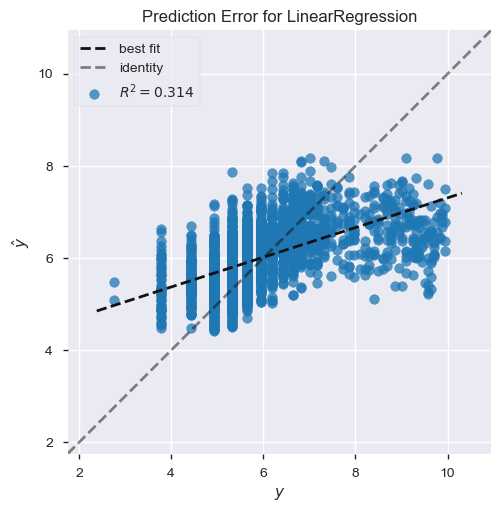

In [56]:
visualizer = PredictionError(LR)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()       

#### Linear Regression Residual Plot<a name="lr_residual"></a>

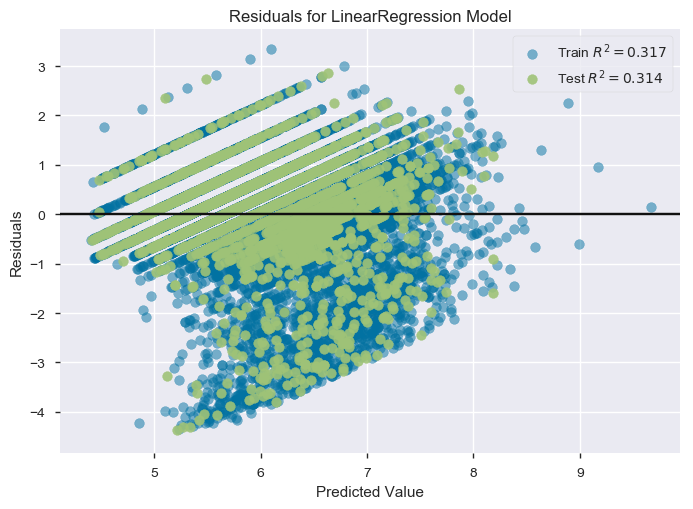

In [57]:
visualizer = ResidualsPlot(LR)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()        

In [58]:
rt.nmse_cv(LR, X_train, y_train)

Mean NMSE: -0.944030110833595


In [59]:
# actual RMSE value
np.sqrt(0.944)

0.9715966241192895

From the residual plot above, does not seem like the residuals follow a strict normal distribution.

---

### XGBoost Regressor Model<a name="xgboost"></a>

Since it does not seem like there is a strict linear relationship we can pick up from the data, the gradient boosting machines such as XGBoost might do better than Linear regression

In [60]:
model_xgb = xgb.XGBRegressor(colsample_bytree=1, gamma=0, objective='reg:linear',
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1, n_estimators=2000,
                             reg_alpha=0, reg_lambda=1,
                             subsample=1, silent=1,
                             random_state =42, nthread = -1)

*Calculating the 5-fold cross validation NMSE might take ~5 mins (2017 Macbook Pro, Intel i5 with 8GB RAM)*

In [63]:
rt.nmse_cv(model_xgb, X_train, y_train)

Mean NMSE: -0.5607819779598328


In [68]:
# actual XGBoost RMSE value
np.sqrt(0.5607)

0.7487990384609211

#### XGBoost Prediction Plot<a name="xgboost_predict_plot"></a>

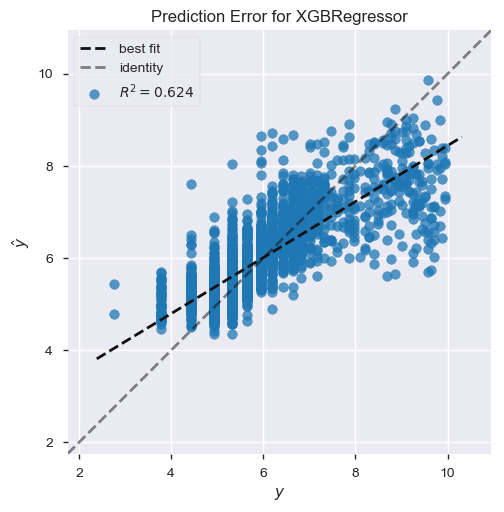

In [61]:
visualizer = PredictionError(model_xgb)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()       

#### XGBoost Residual Plot<a name="xgboost_residual"></a>

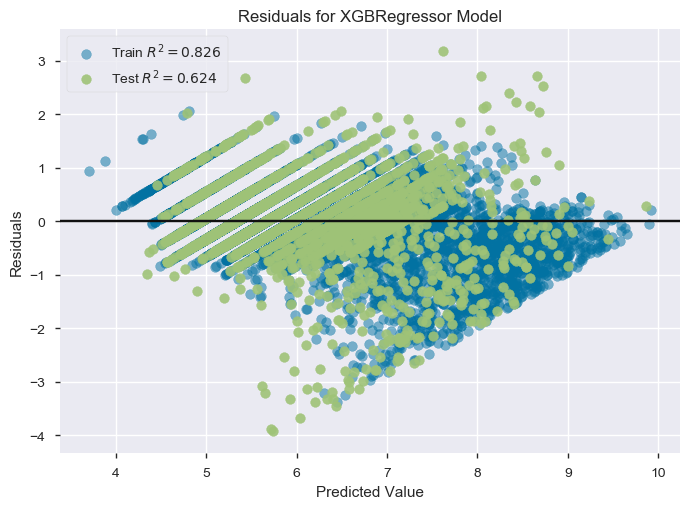

In [62]:
visualizer = ResidualsPlot(model_xgb)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()     

Using XGBoost, the residuals seem to be better fitted compard to the Linear Regression model. 

#### XGBoost Feature Importance<a name="xgboost_feature"></a>

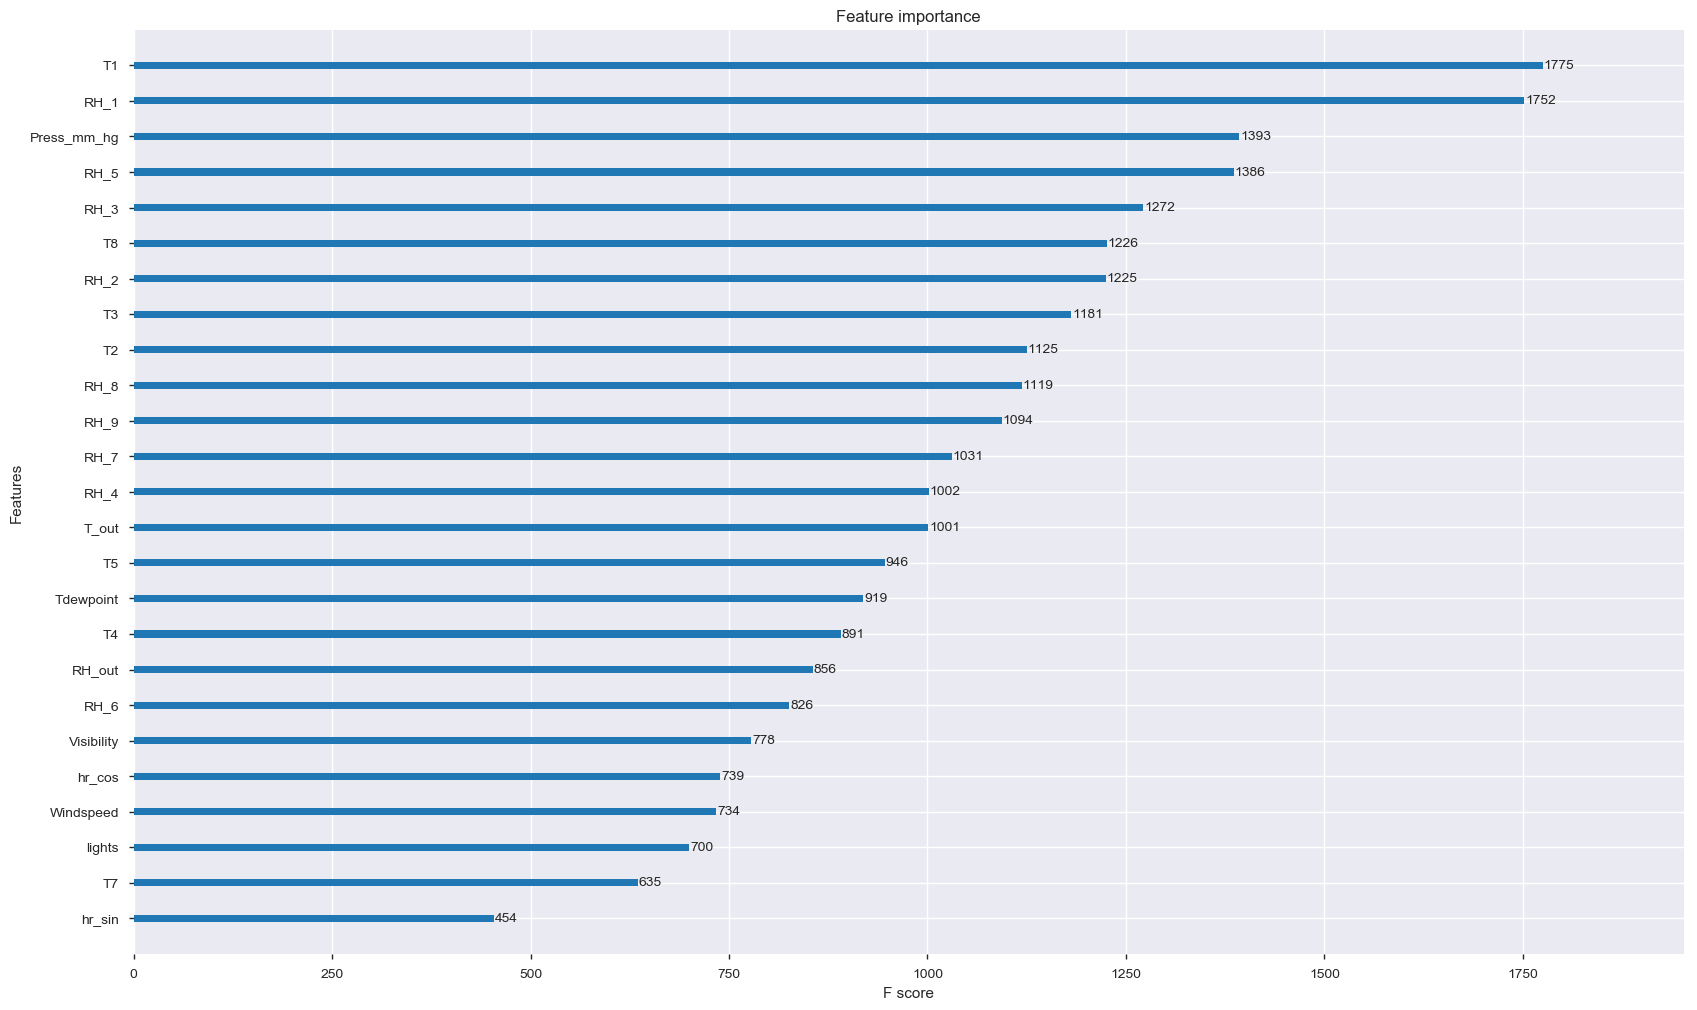

In [64]:
figsize = (20,12)
rt.my_plot_importance(model_xgb.fit(X_train, y_train), figsize=figsize)
plt.show()

#### Explaining the model using SHAP<a name="shap"></a>

Very cool package from https://github.com/slundberg/shap that graphically shows the individual contributions from features of predictions.

In [65]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(X_test)
index = 0 # modify this to see how other predictions went

# visualize the prediction's explanation
shap.force_plot(shap_values[index,:], X.iloc[index,:])

In [66]:
print('Actual value: {}'.format(y_test[index]))

Actual value: 5.942124359831237


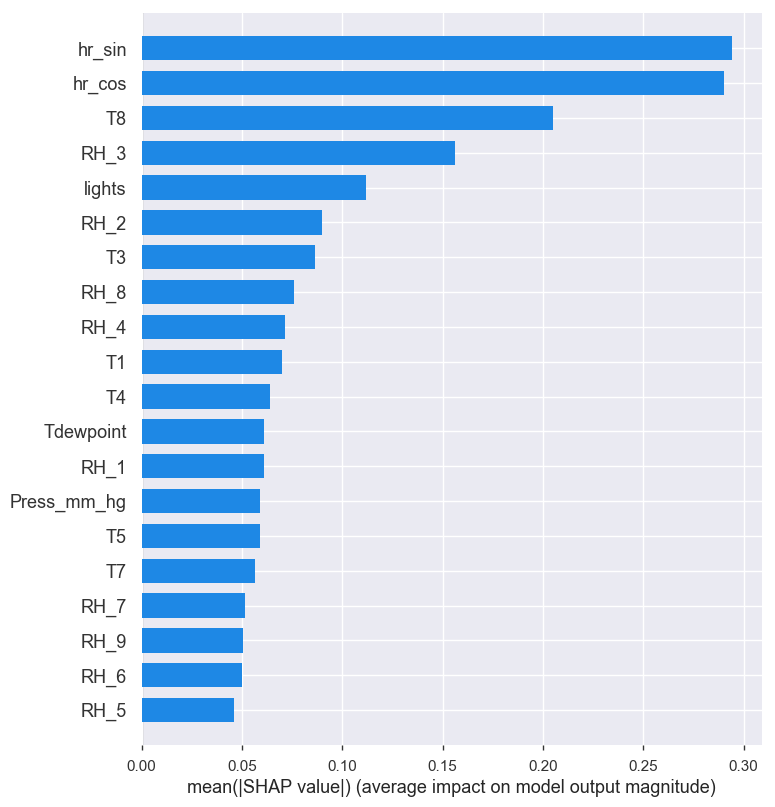

In [67]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Interesting to note that according to shap, the created features from hours actually has a large average impact on model output.

---

# Benefits<a name="benefits"></a>

## Micro level:  <a name="micro"></a>
<img src = "img/off-grid.jpg"> <center>*Image source: https://tinyurl.com/ybmotq7s*</center> <br>
- Renwable energy storage embedded controllers could use the data and model to dynamically allocate  stored energy usage in anticipation of high demand for a given time for individual households energy consumption patterns. Combined with historic/predicted solar insolation model, this could vastly improve efficiency. <br><br>
- The outputs from the prediction output could potentially inform decisions on switching energy plans/providers as some plans offer different peak and off-peak time usage costs.

## Macro level: <a name="macro"></a>
<img src ="img/duck_curve.jpg"> <center>*Image source: https://tinyurl.com/yap8fodk*</center> <br>
- Could alleviate the 'duck-curve' problem with grid connected renwables that energy retailers face. By combining both installed solar capacity data and household electricity prediction, energy retailers can potentially improve lag time on baseload energy production when solar PV generation decreases. <br><br>
- Historically, estimates have been done on a 'top-down' perspective, not accurately reflecting the individual consumption of electricity in households (http://theconversation.com/inaccurate-energy-forecasts-are-costing-us-the-earth-heres-why-42808). Usually resulting in overestimation of demand, creating situations of over-investment in the power network. *"...falsely assumed that historical correlations between energy demand and economic activity would remain consistent...the efficiency of appliances and buildings has improved markedly in recent years thanks to a suite of regulated minimum performance standards"*

---